# ***Proyecto: Coloreo de Grafos***



In [22]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tq

#*Simulated Annealing*

Cada simulación será sobre un grafo *$G = (V, E)$*, donde anotaremos la relación de adyacencia entre nodos por $v \sim u$.

Planteamos el **Problema del Coloreo** $(PC)$ como uno de optimización, donde el objetivo es minimizar mediante Simulated Annealing la funcion de costos $H(x)$, definida como:

$$H(x) = \sum_{v\sim u}{1_{x_v = x_u}}$$

Donde la aplicación $x: V\to C$ representa una configuración de coloreo del grafo, $C$ es el conjunto de colores. La función suma $1$ cada vez que encuentra una arista entre nodos con el mismo color, es decir, enumera la cantidad de 'aristas problemáticas' (es decir, que conectan nodos del mismo color).

Con esto, minimizar la función $H(x)$ corresponde a minimizar la cantidad de aristas que unen nodos con igual color, en consecuencia, hacer que cada nodo tengo un color diferente al de sus vecinos.

Si al minimizar la función se cumple que $H(x) = 0$, entonces el $PC$ tiene solución y esta ha sido encontrada. Mientras que si $H(x) \neq 0$, existira al menos una arista que une dos nodos con el mismo color. Por lo que o bien faltan iteraciones, o bien no es posible resolver el problema con los parametros dados.

In [23]:
#La función recibe un grafo "G" coloreado y un diccionario "colores".
#Devuelve la funcion de costo H(x) asociada al coloreo del grafo.
def H(G, colores):
  problemas = 0
  for e in G.edges():
    if colores[e[0]] == colores[e[1]]:
      problemas += 1
    else:
      pass
  return problemas


*   **Asignación de colores**
  
  Queremos asignar un color cualquiera a cada nodo, para esto, le asignaremos un valor entero de forma aleatoria entre $[1, C]$ y luego asociaremos cada valor a un color diferente. Para esto usaremos un diccionario donde la llave representa el nodo y el valor, el color (número) asignado

In [24]:
#El coloreado inicial del grafo se hará de manera aleatoria
#los grafos serán generados aleatoriamente con nx.erdos_renyi(n,p)
def colores_iniciales(G, C):
    return {nodo : np.random.randint(1, C + 1) for nodo in G.nodes} #Le asignamos un valor a cada nodo

El grafo generado es un grafo simple, por lo que es posible obtener una cota superior mediante el grado máximo del grafo$^1$. [Fuente adjuntas al final del colab], por lo que definimos:

In [25]:
#obtencion cota superior para el numero cromático
#(fuentes adjuntas al final del colab)

def NC_leq(G):
  return max(dict(G.degree).values())+1


*   **Parametros**
  
  Generaremos un grafo $G = (V, E)$ de manera aleatoria, con $n$ nodos y aristas $e$ con probabilidad $p$. Además para el coloreo, aceptaremos $C$ colores

In [26]:
#Parametros

n = 15 #Número de nodos del grafo
p = 0.2 #Probabilidad de la arista
G = nx.erdos_renyi_graph(n, p)  #Grafo aleatorio de n nodos

In [27]:
C = 3 #Colores que tendrá el grafo
color = colores_iniciales(G, C)

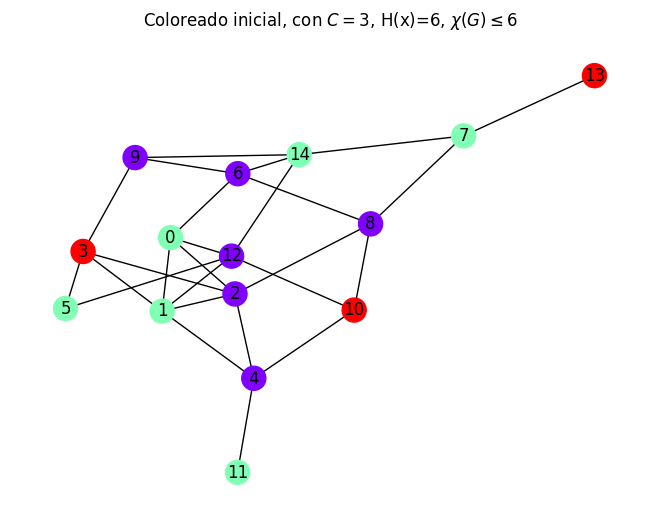

In [28]:
#Asignamos un color a cada nodo segun su valor y generamos el grafo
#Descomentar lo de abajo para ver el grafo inicial, no lo puse para ver porque igual no se entiende nada, son muchos nodos
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=list(color.values()), cmap=plt.cm.rainbow) # Le asignamos un color a cada nodo
plt.title("Coloreado inicial, con $C=$"+str(C)+", H(x)="+str(H(G,color))+', $\chi(G)\leq$'+str(NC_leq(G)))
plt.show()



*   **Construccion del algoritmo**

  Programamos la funcion 'Annealing', la cual será nuestro algoritmo. La función recibira como parametros un grafo $G$, la cantidad maxima de colores $C$, la "temperatura" inicial $T$, la tasa de convergencia $b$ y el número de iteraciones $N$
  
  La interpretacion de $T$ y $b$ corresponde a que la temperatura representa la probabilidad de aceptar peores soluciones durante las primeras iteraciones, mientras mayor es la temperatura, mayor es la probabilidad de aceptar soluciones malas. Por otro lado, la tasa de convergencia regula la velocidad con la que $T$ disminuye a lo largo de las iteraciones. Si la tasa $b$ es alta, $T$ disminuirá rápido, lo que permitirá que con cada iteración se acerque más a la solución óptima.

  Annealing trabaja sobre un coloreado inicial aleatorio, para dado número de colores C. Annealing2 trabaja sobre un coloreado inicial dado.



In [29]:
def Annealing(G, color, T_inicial, b, nf):

    if type(color)==int:
      C=color
      coloreo_actual = colores_iniciales(G, C)
    else:
      C=len(color)
      coloreo_actual = color

    costo_actual = H(G, coloreo_actual) #Guardamos el costo actual del grafo, es decir, el valor de H(x)
    coloreo_nuevo = coloreo_actual
    costo_nuevo = costo_actual
    T = T_inicial

    costos = np.zeros(nf)
    u = np.random.uniform(0,1,nf)

    for i in range(nf):
      cambio_nodo = np.random.choice(list(coloreo_actual.keys())) #Elegimos el nodo a cambiar
      color_vecino = coloreo_actual.copy() #hacemos una copia para no cambiar directamente el diccionario original
      color_vecino[cambio_nodo] = np.random.randint(1, C + 1) #Asignamos un nuevo color (número) al nodo de forma aleatoria
      costo_vecino = H(G, color_vecino) #Evaluamos el coste con el nuevo color
      if costo_vecino < costo_actual or u[i] < np.exp(-(costo_actual - costo_vecino)*T**(-1)):
        coloreo_actual = color_vecino
        costo_actual = costo_vecino
      if costo_actual < costo_nuevo:
        coloreo_nuevo = coloreo_actual
        costo_nuevo = costo_actual
        T *= b
      costos[i] = costo_nuevo

    return coloreo_nuevo, costos

**Implementación sobre el grafo anterior**

In [30]:
color_final = Annealing(G,color,10000,0.5,100000)

In [31]:
alcanza = np.where(color_final[1] == 0)[0][0]
alcanza

44

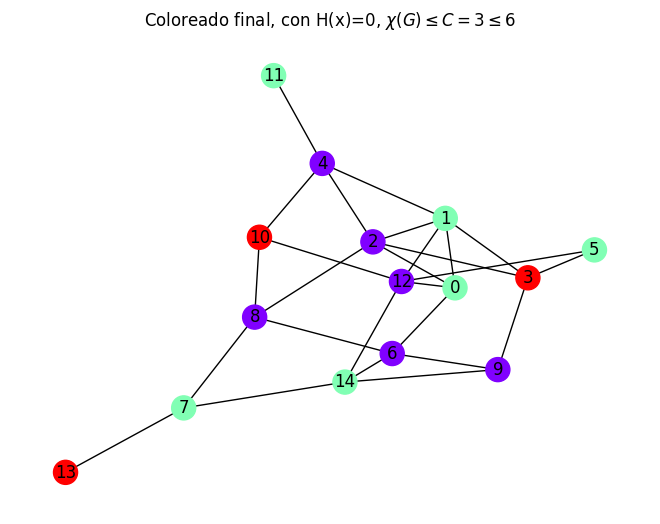

In [32]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=list(color.values()), cmap=plt.cm.rainbow) # Le asignamos un color a cada nodo
plt.title("Coloreado final, con H(x)="+str(H(G,color_final[0]))+', $\chi(G)\leq C=$'+str(C)+'$\leq$'+str(NC_leq(G)))
plt.show()


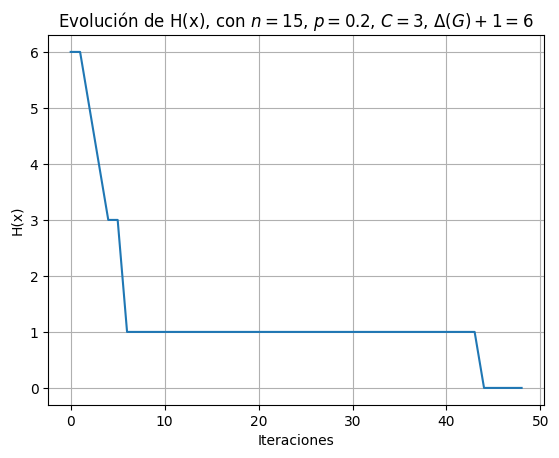

En la iteración  44 se alcanzó el coloreo objetivo.


In [33]:
x = range(alcanza+5)
y = color_final[1][:alcanza+5]
plt.plot(x,y)
plt.ylabel('H(x)')
plt.xlabel('Iteraciones')
plt.title('Evolución de H(x), con $n=15$, $p=0.2$, $C=3$, $\Delta(G)+1=$'+str(NC_leq(G)))
plt.grid()
plt.show()

print('En la iteración ', alcanza, 'se alcanzó el coloreo objetivo.')

#Refinamiento de cota superior para el número cromático

En muchas de las realizaciones de lo anterior se consiguió un número cromático considerablemente menor a la cota obtenida inicialmente, por lo que puede ser útil refinar el acotamiento. Para ello, utilizaremos el algoritmo Annealing para buscar coloreos de peso 0 (es decir, soluciones del PC) con cantidades de coloreado menores a la cota (que es una cantidad factible garantizada). En caso de encontrar un coloreo con un número menor, todos los números mayores también serán factibles.


In [34]:
#Parametros, creación del grafo y rango de

n = 25 #Número de nodos del grafo
p = 0.5 #Probabilidad de la arista
G = nx.erdos_renyi_graph(n, p)  #Grafo aleatorio de n nodos
c_leq = NC_leq(G)
print('El NC debe ser menor a', c_leq)

El NC debe ser menor a 20


In [35]:
T=3
b=0.1
nf=1000
k=8

<ipython-input-29-846da7c6e354>:23: RuntimeWarning: overflow encountered in exp
  if costo_vecino < costo_actual or u[i] < np.exp(-(costo_actual - costo_vecino)*T**(-1)):


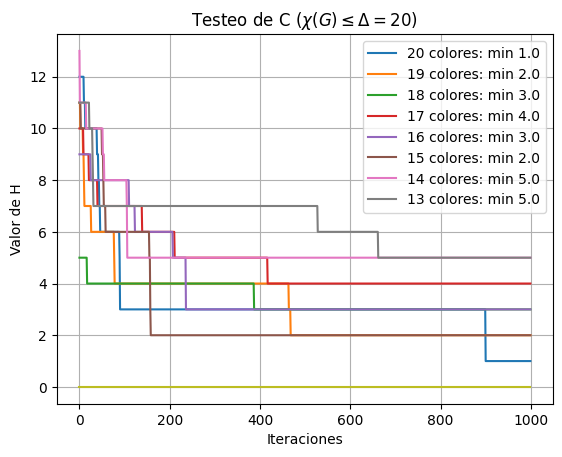

In [36]:
h = np.zeros(k, dtype='object')
x = np.zeros(k, dtype="object")

for i in range(k):
  h[i], x[i] = Annealing(G,int(c_leq-i),T,b,nf)

fig, ax = plt.subplots()
Pasos = range(nf)
for i in range(k):
   ax.plot(Pasos, x[i], label=str(int(c_leq-i))+' colores: min '+str(min(x[i])))
ax.plot(Pasos, np.zeros(nf))
ax.legend(loc = 'upper right')
ax.set_title('Testeo de C ($\chi(G)\leq\Delta=$'+str(c_leq)+')')
ax.set_xlabel('Iteraciones')
ax.set_ylabel('Valor de H')
plt.grid()
plt.show()

<ipython-input-29-846da7c6e354>:23: RuntimeWarning: overflow encountered in exp
  if costo_vecino < costo_actual or u[i] < np.exp(-(costo_actual - costo_vecino)*T**(-1)):


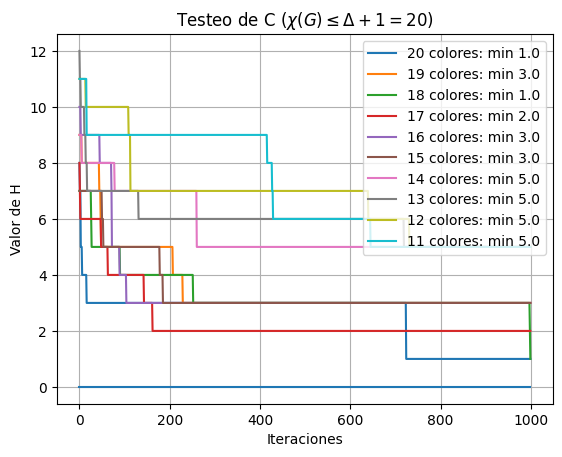

In [37]:
k=10

h = np.zeros(k, dtype='object')
x = np.zeros(k, dtype="object")

for i in range(k):
  h[i], x[i] = Annealing(G,int(c_leq-i),T,b,nf)

fig, ax = plt.subplots()
Pasos = range(nf)
for i in range(k):
   ax.plot(Pasos, x[i], label=str(int(c_leq-i))+' colores: min '+str(min(x[i])))
ax.plot(Pasos, np.zeros(nf))
ax.legend(loc = 'upper right')
ax.set_title('Testeo de C ($\chi(G)\leq\Delta+1=$'+str(c_leq)+')')
ax.set_xlabel('Iteraciones')
ax.set_ylabel('Valor de H')
plt.grid()
plt.show()

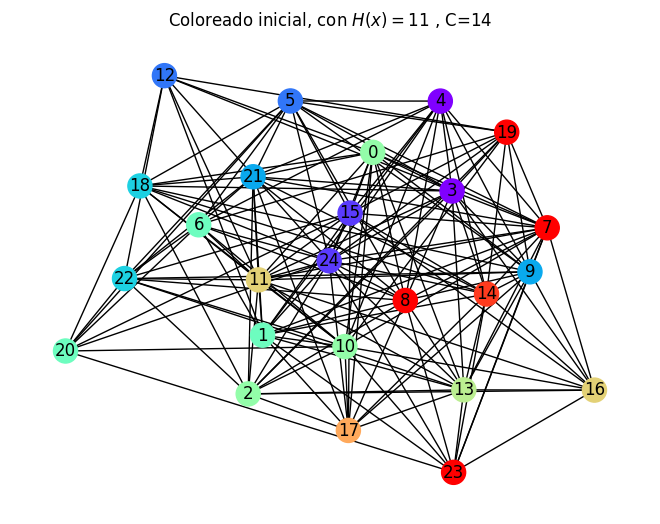

In [38]:
color = colores_iniciales(G, 14)

#Asignamos un color a cada nodo segun su valor y generamos el grafo
#Descomentar lo de abajo para ver el grafo inicial, no lo puse para ver porque igual no se entiende nada, son muchos nodos
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=list(color.values()), cmap=plt.cm.rainbow) # Le asignamos un color a cada nodo
plt.title("Coloreado inicial, con $H(x)=$"+str(H(G,color))+" , C=14")
plt.show()

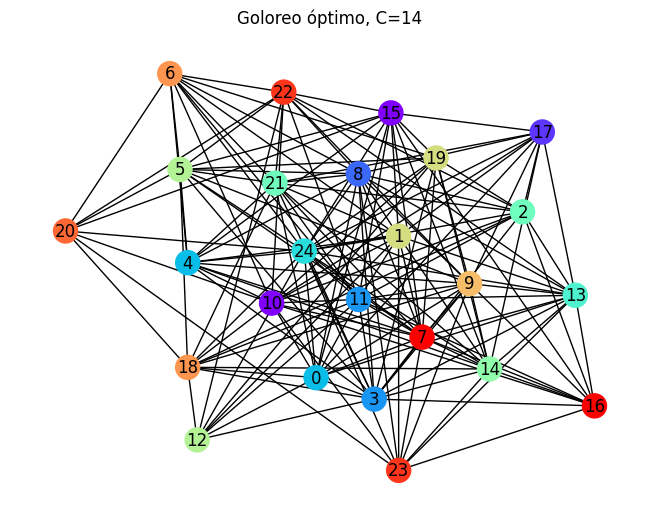

In [39]:
color = h[4]

#Asignamos un color a cada nodo segun su valor y generamos el grafo
#Descomentar lo de abajo para ver el grafo inicial, no lo puse para ver porque igual no se entiende nada, son muchos nodos
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=list(color.values()), cmap=plt.cm.rainbow) # Le asignamos un color a cada nodo
plt.title("Goloreo óptimo, C=14")
plt.show()

**Ahora con un grafo más grande:**

In [40]:
#Parametros, creación del grafo y rango de

n = 100 #Número de nodos del grafo
p = 0.2 #Probabilidad de la arista
G = nx.erdos_renyi_graph(n, p)  #Grafo aleatorio de n nodos
c_leq = NC_leq(G)
print('El NC debe ser menor a', c_leq)
T=3
b=0.1
nf=1000000
k=8

El NC debe ser menor a 31


**FUENTES**

1.- https://repositorio.unican.es/xmlui/bitstream/handle/10902/3099/Maria%20Rosa%20Murga%20Diaz.pdf?sequence=4#:~:text=El%20número%20cromático%20de%20un,grafo%20G%20es%20k-cromático. (Teorema 2.1)